In [1]:
%env OMP_NUM_THREADS=10
%pylab inline
%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=10
Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
import os
import sys
import cv2
import math
import pickle
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
from collections import namedtuple
import importlib
import inspect
from collections import namedtuple
import time
import glob
from imageio import imread, imsave
print('USE GPU #{} Host={}'.format(os.environ.get('CUDA_VISIBLE_DEVICES'), os.uname()[1]))

/home/ono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


USE GPU #1 Host=8go


In [3]:
LOCAL_PATH = '../'
if LOCAL_PATH not in sys.path:
    sys.path.append(LOCAL_PATH)
from common.tf_layer_utils import *
from mydatasets import *
from det_tools import *
from inference import *
MODEL_PATH = '../models/'
if MODEL_PATH not in sys.path:
    sys.path.append(MODEL_PATH)
COMMON_PATH = '../common/'
if COMMON_PATH not in sys.path:
    sys.path.append(COMMON_PATH)
    
from io_utils import read_text
from jupyter_utils import display_image_batch


In [4]:
given_config = namedtuple('params', 'model')
given_config.model = '../release/models/outdoor/'
given_config.top_k = 1024
yfcc_dir = '../release/outdoor_examples/'
given_config.img_dir = os.path.join(yfcc_dir, 'images')
given_config.dpt_dir = os.path.join(yfcc_dir, 'depths')
given_config.seq_names = ['sacre_coeur']
given_config.dist_thresh = 5

In [5]:
# load config file
config_path = os.path.join(given_config.model, 'config.pkl')
try:
    with open(config_path, 'rb') as f:
        config = pickle.load(f)
except:
    raise ValueError('Fail to open {}'.format(config_path))

# overwrite each given_config parameters
for attr, dst_val in sorted(vars(given_config).items()):
    if attr.startswith('_'):
        continue
    elif hasattr(config, attr):
        src_val = getattr(config, attr)
        if src_val != dst_val:
            print('Overwrite {} : {} --> {}'.format(attr, src_val, dst_val))
            setattr(config, attr, dst_val)
    else:
        print('Add {} {}'.format(attr, dst_val))
        setattr(config, attr, dst_val)

Add dist_thresh 5
Add dpt_dir ../release/outdoor_examples/depths
Add img_dir ../release/outdoor_examples/images
Add model ../release/models/outdoor/
Add seq_names ['sacre_coeur']
Overwrite top_k : 512 --> 1024


In [6]:
tf.reset_default_graph()
batch_size = 1 # fixed
data_loader = RawSfMDataset(longer_edge=640)

dataset = data_loader.get_dataset(config.dpt_dir, config.img_dir, 
                config.seq_names, phase='valid', shuffle=True, seed=12345, max_examples=500)

next_batch = dataset.make_one_shot_iterator().get_next()
photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, theta_params, use_aug = next_batch
rgbs1 = tf.concat([photos1, photos1, photos1], axis=-1)
rgbs2 = tf.concat([photos2, photos2, photos2], axis=-1)
# Not apply any augmentations
thetas1 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
thetas2 = tf.tile(tf.eye(3)[None], [batch_size, 1, 1])
inv_thetas1 = tf.matrix_inverse(thetas1)
inv_thetas2 = tf.matrix_inverse(thetas2)
# next_batch = [photos1, photos2, depths1, depths2, valid_masks1, valid_masks2, 
#               c2Tc1s, c1Tc2s, c1Tws, c2Tws, Ks1, Ks2, 
#               thetas1, thetas2, inv_thetas1, inv_thetas2, theta_params]

# photos1 = tf.placeholder(tf.float32, [None,None,None,1])
# photos2 = tf.placeholder(tf.float32, [None,None,None,1])
is_training = tf.placeholder(tf.bool)

sacre_coeur has 4631 examples
---> actual size=500
aug_mode=none max_rad=0.0, max_scale_log=0.0


### Detect and describe local features

In [7]:
DET = importlib.import_module(config.detector)
detector = DET.Model(config, is_training)

if config.use_nms3d:
    print('Apply 3D NMS instead.')
    heatmaps1, det_endpoints = build_multi_scale_deep_detector_3DNMS(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector_3DNMS(config, detector, photos2, reuse=True)
else:
    heatmaps1, det_endpoints = build_multi_scale_deep_detector(config, detector, photos1, reuse=False)
    heatmaps2, det_endpoints2 = build_multi_scale_deep_detector(config, detector, photos2, reuse=True)

degree_maps1 = visualize_degree_map(det_endpoints['ori_maps'])
degree_maps2 = visualize_degree_map(det_endpoints2['ori_maps'])

Act-Fn:  <function get_activation_fn.<locals>.<lambda> at 0x7f0cc8151ea0>
Apply 3D NMS instead.
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/weights:0 is illegal; using ConvOnlyResNet/ori_conv/weights_0 instead.
INFO:tensorflow:Summary name ConvOnlyResNet/ori_conv/biases:0 is illegal; using ConvOnlyResNet/ori_conv/biases_0 instead.
PAD=16, #conv=8, ksize=5 ori-ksize=5
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Scales (0.707107~1.41 #5): [1.41421356 1.18920712 1.         0.84089642 0.70710678]
PAD=16, #conv=8, ksize=5 ori-ksize=5


In [8]:
# extract patches
kpts1 = det_endpoints['kpts']
kpts2 = det_endpoints2['kpts']
batch_inds1 = det_endpoints['batch_inds']

kp_patches1 = build_patch_extraction(config, det_endpoints, photos1)
kp_patches2 = build_patch_extraction(config, det_endpoints2, photos2)

# Descriptor
DESC = importlib.import_module(config.descriptor)
descriptor = DESC.Model(config, is_training)
desc_feats1, desc_endpoints = descriptor.build_model(kp_patches1, reuse=False) # [B*K,D]
desc_feats2, _          = descriptor.build_model(kp_patches2, reuse=True) # [B*K,D]

Act-Fn:  <function relu at 0x7f0c4b116510>
===== SimpleDesc (reuse=False) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)
===== SimpleDesc (reuse=True) =====
#1 conv-bn-act (?, 16, 16, 64)
#2 conv-bn-act (?, 8, 8, 128)
#3 conv-bn-act (?, 4, 4, 256)
FLAT (?, 4096)
Feat-Norm: L2-NORM
FEAT (?, 256)


In [9]:
nn_dist, nn_inds2, _, _, _ = nearest_neighbors(desc_feats1, desc_feats2)
kpts2_corr = tf.cast(tf.gather(kpts2, nn_inds2), tf.float32)

### Check with Ground truth

In [10]:
kpts1_int = tf.cast(kpts1, tf.int32)
heatmaps1w, visible_masks1, xy_maps1to2 = \
    inverse_warp_view_2_to_1(heatmaps2, depths2, depths1, c2Tc1s, 
                            K1=Ks1, K2=Ks2, 
                            inv_thetas1=inv_thetas1, thetas2=thetas2,
                            depth_thresh=config.depth_thresh)
heatmaps2w, visible_masks2, xy_maps2to1 = \
    inverse_warp_view_2_to_1(heatmaps1, depths1, depths2, c1Tc2s, 
                            K1=Ks2, K2=Ks1,
                            inv_thetas1=inv_thetas2, thetas2=thetas1,
                            depth_thresh=config.depth_thresh)
visible_masks1 = visible_masks1 * valid_masks1 # take 'and'
visible_masks2 = visible_masks2 * valid_masks2

kpts2w = batch_gather_keypoints(xy_maps1to2, batch_inds1, kpts1_int)
kpvis2w = batch_gather_keypoints(visible_masks1, batch_inds1, kpts1_int)[:,0] 

match_dist = tf.maximum(tf.cast(tf.reduce_sum(tf.squared_difference(kpts2_corr, kpts2w), axis=1), tf.float32), 1e-6)
match_dist = tf.sqrt(match_dist)
is_match = tf.cast(tf.less_equal(match_dist, config.dist_thresh), tf.float32) * kpvis2w


# SIFT
sift_endpoints = build_competitor_matching_estimation(config, dist_thresh=config.dist_thresh)

In [11]:
tfconfig = tf.ConfigProto()
tfconfig.gpu_options.allow_growth = True 
sess = tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

# load model
saver = tf.train.Saver()
print('Load trained models...')

if os.path.isdir(config.model):
    checkpoint = tf.train.latest_checkpoint(config.model)
    model_dir = config.model
else:
    checkpoint = config.model
    model_dir = os.path.dirname(config.model)

if checkpoint is not None:
    print('Checkpoint', os.path.basename(checkpoint))
    print("[{}] Resuming...".format(time.asctime()))
    saver.restore(sess, checkpoint)
else:
    raise ValueError('Cannot load model from {}'.format(model_dir))    
print('Done.')

Load trained models...
Checkpoint models-latest-42000
[Wed Dec 19 17:48:59 2018] Resuming...
INFO:tensorflow:Restoring parameters from ../release/models/outdoor/models-latest-42000
Done.


In [12]:
feed_dict = {
    is_training: False,
}
fetch_dict = {
    'photos1': photos1,
    'photos2': photos2,
    'rgbs1': rgbs1,
    'rgbs2': rgbs2,
    'kpts1': kpts1,
    'kpts2': kpts2,
    'kpts2_corr': kpts2_corr,
    'is_match': is_match,
    'degree_maps1': degree_maps1,
    'degree_maps2': degree_maps2,
    'xy_maps1to2': xy_maps1to2,
    'visible_masks1': visible_masks1,
}
outs = sess.run(fetch_dict, feed_dict=feed_dict)

In [16]:
outs['photos1'].shape

(1, 640, 421, 1)

In [13]:
match_pair = np.concatenate([outs['kpts1'], outs['kpts2_corr']], axis=1)
match_pair = match_pair[outs['is_match']==1]

#Matches = 64


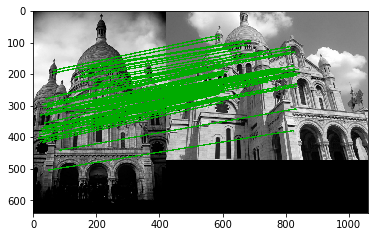

In [14]:
rgb1 = outs['rgbs1'][0]
rgb2 = outs['rgbs2'][0]
match_pairs = np.concatenate([outs['kpts1'], outs['kpts2_corr']], axis=1)
match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)
fig = plt.imshow(canvas)

xs = match_pairs[:,[0,2]]
xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);
print('#Matches = {}'.format(len(match_pairs)))

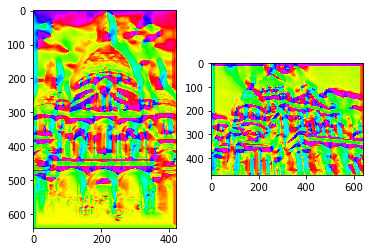

In [15]:
plt.subplot(121)
plt.imshow(outs['degree_maps1'][0])
plt.subplot(122)
plt.imshow(outs['degree_maps2'][0])

## SIFT

In [ ]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=config.top_k, contrastThreshold=1e-5)
sift_in1 = (rgb1[...,0]*255).astype(np.uint8)
sift_in2 = (rgb2[...,0]*255).astype(np.uint8)
kp1, des1 = sift.detectAndCompute(sift_in1,None)
kp2, des2 = sift.detectAndCompute(sift_in2,None)
kp1 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp1])
kp2 = np.array([[kp.pt[0],kp.pt[1]] for kp in kp2])
print('#SIFT keypoints = {}, {}'.format(len(kp1), len(kp2)))

In [ ]:
feed_dict = {
    sift_endpoints['feats1_ph']: des1,
    sift_endpoints['feats2_ph']: des2,
    sift_endpoints['kpts1_ph']: kp1,
    sift_endpoints['kpts2_ph']: kp2,
    sift_endpoints['xy_maps1to2_ph']: outs['xy_maps1to2'],
    sift_endpoints['visible_masks1_ph']: outs['visible_masks1']
}
fetch_dict = {
    'kpts2_corr': sift_endpoints['kpts2_corr'],
    'is_match': sift_endpoints['is_match'],
}
outs = sess.run(fetch_dict, feed_dict)

In [ ]:
match_pairs = np.concatenate([kp1, outs['kpts2_corr']], axis=1)
match_pairs = match_pairs[outs['is_match']==1]

h1, w1 = rgb1.shape[:2]
h2, w2 = rgb2.shape[:2]
canvas = np.zeros((max(h1, h2), w1+w2, 3), dtype=rgb1.dtype)
canvas[:h1, :w1] = rgb1
canvas[:h2, w1:] = rgb2
fig = plt.figure(frameon=False)
fig = plt.imshow(canvas)

xs = match_pairs[:,[0,2]]
xs[:,1] += w1
ys = match_pairs[:,[1,3]]

lw = .25
alpha = 1
sf = 5
lw = .2
markersize = 1

plt.plot(
    xs.T, ys.T,
    alpha=alpha,
    linestyle="-",
    linewidth=lw,
    aa=False,
    marker='.',
    markersize=markersize,
    color=[0.0, 0.67, 0.0],
);
print('#Matches = {}'.format(len(match_pairs)))